In [1]:
import os
import copy
import time
import glob
import random
from PIL import Image
from typing import List, Tuple

import numpy as np
import pylab as pl
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from IPython import display
import wandb

import torch
from torch import nn
from torchvision import transforms, models
from torch.utils.data import Dataset
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR
from torchvision.models.vision_transformer import VisionTransformer 

/home/collab/env_jupyter/lib/python3.8/site-packages/torchvision/datapoints/__init__.py:12: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may have in this issue: https://github.com/pytorch/vision/issues/6753, and you can also check out https://github.com/pytorch/vision/issues/7319 to learn more about the APIs that we suspect might involve future changes. You can silence this warning by calling torchvision.disable_beta_transforms_warning().
  warnings.warn(_BETA_TRANSFORMS_WARNING)
/home/collab/env_jupyter/lib/python3.8/site-packages/torchvision/transforms/v2/__init__.py:54: UserWarning: The torchvision.datapoints and torchvision.transforms.v2 namespaces are still Beta. While we do not expect major breaking changes, some APIs may still change according to user feedback. Please submit any feedback you may h

In [2]:
SEED = 42

random.seed(SEED)
torch.manual_seed(SEED)
OHE = False

## Dataset

In [3]:
class ImageDataset(Dataset):
    """General pytorch dataset.

    The data should be build with the following structure.
    """

    def __init__(
        self,
        img_paths: List[str],
        read_img_fn: callable,
        transform=None,
        do_ohe: bool = False
    ):
        self.__read_img_fn = read_img_fn
        
        self.__img_paths = img_paths
        self.__transform = transform
        self.__do_ohe = do_ohe

        self.n_classes = 0

    def __getitem__(self, index: int) -> Tuple[np.array, torch.Tensor]:
        img_path = self.__img_paths[index]
        label = int(img_path.split(os.path.sep)[-3])
        

        self.n_classes = max(self.n_classes, label)
        
        image = self.__read_img_fn(img_path)
        index = index % len(self.__img_paths)

        if self.__transform is not None:
            image = self.__transform(image)

        if self.__do_ohe:
            label_ohe = np.zeros((46))
            label_ohe[label] = 1
            label = label_ohe

        return image, label

    def __len__(self) -> int:
        return len(self.__img_paths)

In [4]:
train_path = glob.glob("./output/train_CO/**/**/image.png")
test_path = glob.glob("./output/test_CO/**/**/image.png")

transform = transforms.Compose([transforms.ToTensor(), v2.ToDtype(torch.float)])

train_ds = ImageDataset(train_path, Image.open, transform, do_ohe=OHE)
train_loader = DataLoader(train_ds, batch_size=100, shuffle=True)

test_ds = ImageDataset(test_path, Image.open, transform, do_ohe=OHE)
test_loader = DataLoader(test_ds, batch_size=100, shuffle=True)

In [5]:
def _show_progress(history, phases):
    plt.figure(figsize=(15,10))

    for phase in phases:
        pl.subplot(1, 2, 1)
        pl.title(f'Best Acc: {max(history[phase]["acc"])}')

        pl.plot(history[phase]['acc'], label=phase.capitalize())
        pl.legend()

    for phase in phases:
        pl.subplot(1, 2, 2)
        pl.title(f'Best loss: {min(history[phase]["loss"])}')
        pl.plot(history[phase]['loss'], label=phase.capitalize())

        pl.legend()
    display.clear_output(wait=True) 
    display.display(pl.gcf())
    plt.close() 
    
def train_model(
    model, 
    dataloaders, 
    criterion, 
    optimizer, 
    num_epochs=25, 
    is_inception=False, 
    do_validation=True, 
    regression=False,
    plot_acc=False,
):
    since = time.time()

    wandb.init(project="taixi", config={
        "epochs": num_epochs,
        "lr": LR,
        "first_n_layers": FIRST_N_LAYERS,
        "dropout": DROPOUT,
    })
    
    history = {}
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    best_acc_std = 0.0
    best_loss = 0.0
    best_loss_std = 0.0
    
    phases = ['train']
    
    if do_validation:
        phases.append('val')
        
    epoch_loss = 0
    epoch_acc = 0
    try:
        for epoch in range(num_epochs):
            # Each epoch has a training and validation phase
    
            res = dict()
            for phase in phases:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode
    
                running_loss = []
                running_acc = []
    
                pbar = tqdm(dataloaders[phase], desc='Time, he\'s waiting in the wings')
                # Iterate over data.
                for inputs, labels in pbar:
                    inputs = inputs.to(device)
                    labels = labels.to(device)
    
                    inputs = inputs.type(torch.float32)
    
                    # zero the parameter gradients
                    optimizer.zero_grad()
    
                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        # Get model outputs and calculate loss
                        # Special case for inception because in training it has an auxiliary output. In train
                        #   mode we calculate the loss by summing the final output and the auxiliary output
                        #   but in testing we only consider the final output.
                        outputs = model(inputs)                      
                        loss = criterion(outputs, labels)
    
                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
    
                    # statistics
                    running_loss.append((loss.item() * inputs.size(0)) / len(outputs))
                    preds = torch.argmax(outputs, 1).detach().cpu()
    
                    # labels = torch.argmax(labels, 1).reshape(-1).detach().cpu()
                    labels = labels.reshape(-1).detach().cpu()
                    
                    # aux = ((preds > 0.5).double() == labels)
                    # acc = (torch.sum(aux).double().cpu().detach().numpy() / len(outputs))
                    acc = accuracy_score(labels, preds)
                    running_acc.append(acc)
                        
                    pbar.set_description('Epoch {}/{} - {} - ACC: {:.4f} LOSS: {:.4f}'.format(epoch, num_epochs - 1, phase.capitalize(), np.mean(running_acc), np.mean(running_loss)))
                
                epoch_loss = np.mean(running_loss)
                epoch_acc = np.mean(running_acc)
    
                res[f"{phase}_loss"] = epoch_loss 
                res[f"{phase}_accuracy"] = epoch_acc
    
                # deep copy the model
                if (phase == 'val' or not 'val' in phases) and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    best_loss = epoch_loss
    
                    best_loss_std = np.std(running_loss)
                    best_acc_std = np.std(running_acc)
    
                    best_model_wts = copy.deepcopy(model.state_dict())
    
                if phase not in history:
                    history[phase] = {"acc": [], "loss": []}
    
                history[phase]["acc"].append(epoch_acc)
                history[phase]["loss"].append(epoch_loss)
    
            wandb.log(res)
            if plot_acc:
                _show_progress(history, phases)
    except KeyboardInterrupt:
        print('Interrupted')
    except Exception as e:
        print(e)
        traceback.print_exc()
    finally:
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print('Best val Acc: [{:4f}-{:4f}]'.format(best_acc - best_acc_std/2, best_acc + best_acc_std/2))
        
        # load best model weights
        model.load_state_dict(best_model_wts)
        return model, history

In [6]:
LR = 0.00001
FIRST_N_LAYERS = 1
DROPOUT = 0.7

In [7]:
net = models.resnet50(pretrained=models.ResNet50_Weights.DEFAULT)

for i, param in enumerate(net.parameters()):
    if i == FIRST_N_LAYERS:
        break
    
    param.requires_grad = False

    
num_ftrs = net.fc.in_features
    
net.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3,
                           bias=False)


net.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(inplace=True),
    nn.Dropout(p=DROPOUT),
    nn.Linear(128, 47),
)


/home/collab/env_jupyter/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/collab/env_jupyter/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [8]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

## Entrenament

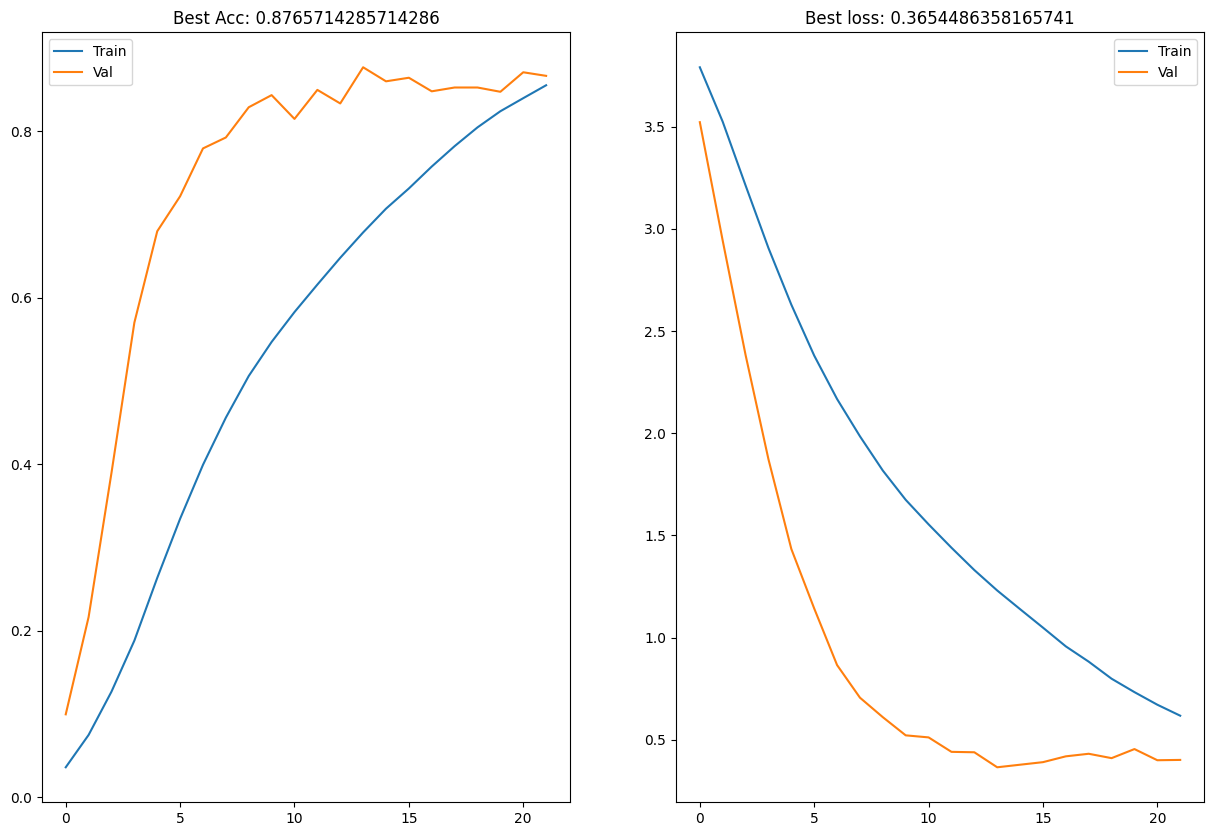

Time, he's waiting in the wings:   0%|          | 0/470 [00:00<?, ?it/s]

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=LR)

net = net.to(device)

net, history = train_model(
    net, 
    {"train": train_loader, "val": test_loader}, 
    criterion, 
    optimizer,
    num_epochs=100, 
    do_validation=True,
    plot_acc=True,
    regression=False
)

In [15]:
# torch.save(net.state_dict(), "res_9.pt")

In [17]:
max(history['val']['acc'])

0.8802857142857142

# Anàlisi

In [31]:
# net.load_state_dict(torch.load("res.pt", weights_only=True))
net = net.eval();

In [32]:
aux = np.zeros(5)
aux[2] = -5

np.argsort(aux)

array([2, 0, 1, 3, 4])

In [33]:
results = []
ground_truth = []

In [34]:
for inputs, labels in tqdm(test_loader):
    res = net(inputs.to(device)).detach()
    
    results = results + torch.argmax(res, axis=-1).detach().cpu().tolist()
    ground_truth = ground_truth + labels.detach().cpu().tolist()

  0%|          | 0/5 [00:00<?, ?it/s]

In [35]:
print(classification_report(ground_truth, results))

              precision    recall  f1-score   support

           0       0.90      0.90      0.90        10
           1       0.67      0.60      0.63        10
           2       0.90      0.90      0.90        10
           3       0.86      0.60      0.71        10
           4       1.00      1.00      1.00        10
           5       0.77      1.00      0.87        10
           6       1.00      1.00      1.00        10
           7       1.00      0.90      0.95        10
           8       0.80      0.80      0.80        10
           9       1.00      1.00      1.00        10
          10       0.91      1.00      0.95        10
          11       1.00      1.00      1.00        10
          12       0.77      1.00      0.87        10
          13       0.82      0.90      0.86        10
          14       0.75      0.90      0.82        10
          15       1.00      1.00      1.00        10
          16       0.91      1.00      0.95        10
          17       0.83    

In [ ]:
cm = confusion_matrix(ground_truth, results)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

disp.plot(include_values=False);

In [ ]:
np.argsort(cm[7])